<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 3: Kugelfunktionen
# Topography from spherical harmonics
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

We first import libraries we will need. This time, besides the standard `numpy` and `matplotlib`
libraries, we need special functions from the `scipy` package.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

----
## Read Stokes coefficients for topography

We want to reconstruct a topography map $U(\theta,\phi)$ from the Stokes coefficients $C_{nm}$,
using the spherical harmonics $Y_{nm}(\theta,\phi)$:
$$
U(\theta,\phi) = \sum\limits_{n=0}^{n_{max}} \sum\limits_{m=0}^{n} C_{nm} Y_{nm}(\theta,\phi)
$$

The Stokes coefficients $C_{nm}$ we read from the file `TOPO.nm` in the data directory, 
which contains the **coefficients** for the spherical harmonic reconstruction of topography:

In [2]:
ls data; head data/TOPO.nm

EIGEN2.nm         IGRF13.nm         TOPO.nm           igrf13coeffs.txt
     n     m    Cnm           Snm
     0     0   -0.2378E+04    0.0000E+00
     1     0    0.6549E+03    0.0000E+00
     1     1    0.6301E+03    0.3882E+03
     2     0    0.5630E+03    0.0000E+00
     2     1    0.3306E+03    0.3097E+03
     2     2   -0.4122E+03   -0.6366E+02
     3     0   -0.1623E+03    0.0000E+00
     3     1   -0.1476E+03    0.1286E+03
     3     2   -0.4339E+03    0.4820E+03


Note that the Stokes coefficients $C_{nm}$ have a **cosine** and a **sine** term!

- We use the `loadtxt` module from the `numpy` package, skip the first line, because it is a header line.

- We then sort the entries into a 3D array `stokes` (our $C_{nm}$) for the different degree $n$ and order $m$ values.

- Note that we initially fill the array with `nan`, meaning **not a number**, to mark the positions
with $m>n$ as positions without data.

In [3]:
# open topography model data file and read data
infile1='data/TOPO.nm'
data = np.loadtxt(fname=infile1,skiprows=1)
print(data.shape)
# sort Stokes coefficients into array stokes
nmax = 127
mmax = nmax
Cnm = np.zeros((nmax+1)*(mmax+1)*2).reshape((nmax+1),(mmax+1),2)
Cnm = Cnm*np.nan
for i in range(data.shape[0]):
    n = int(data[i,0])
    m = int(data[i,1])
    Cnm[n,m,0] = data[i,2]
    Cnm[n,m,1] = data[i,3]
    
# check shape and first coefficients
print(Cnm.shape)
n=0;m=0; print(n,m,Cnm[n][m])
n=1;m=0; print(n,m,Cnm[n][m])
n=1;m=1; print(n,m,Cnm[n][m])
n=1;m=2; print(n,m,Cnm[n][m])

(8256, 4)
(128, 128, 2)
0 0 [-2378.     0.]
1 0 [654.9   0. ]
1 1 [630.1 388.2]
1 2 [nan nan]


Next, we search for the **abolute maximum** for both the sine and cosine contributions in $C_{nm}$.

In [4]:
Cnm_max = np.nanmax(np.abs(Cnm[:,:,0]))
print('Cosine abs max: ',Cnm_max)
Snm_max = np.nanmax(np.abs(Cnm[:,:,1]))
print('Sine abs max:   ',Snm_max)

Cosine abs max:  2378.0
Sine abs max:    560.2


We plot a map of the scaled strength of both the cosine and sine coeffients. We restrict the
map to $n<20$, because the main signal for the topography is contained in small $n$ values.

Note that we first build two 2D arrays for the $n$ and $m$ indices, using `np.meshplot`, and
using the keyword `indexing='ij'` for the correct axis.

In [5]:
print(Cnm.shape)
nn = np.linspace(0,Cnm.shape[0]-1,Cnm.shape[0])
mm = np.linspace(0,Cnm.shape[1]-1,Cnm.shape[1])
NN,MM = np.meshgrid(nn,mm,indexing='ij')
print(NN.shape,MM.shape)

(128, 128, 2)
(128, 128) (128, 128)


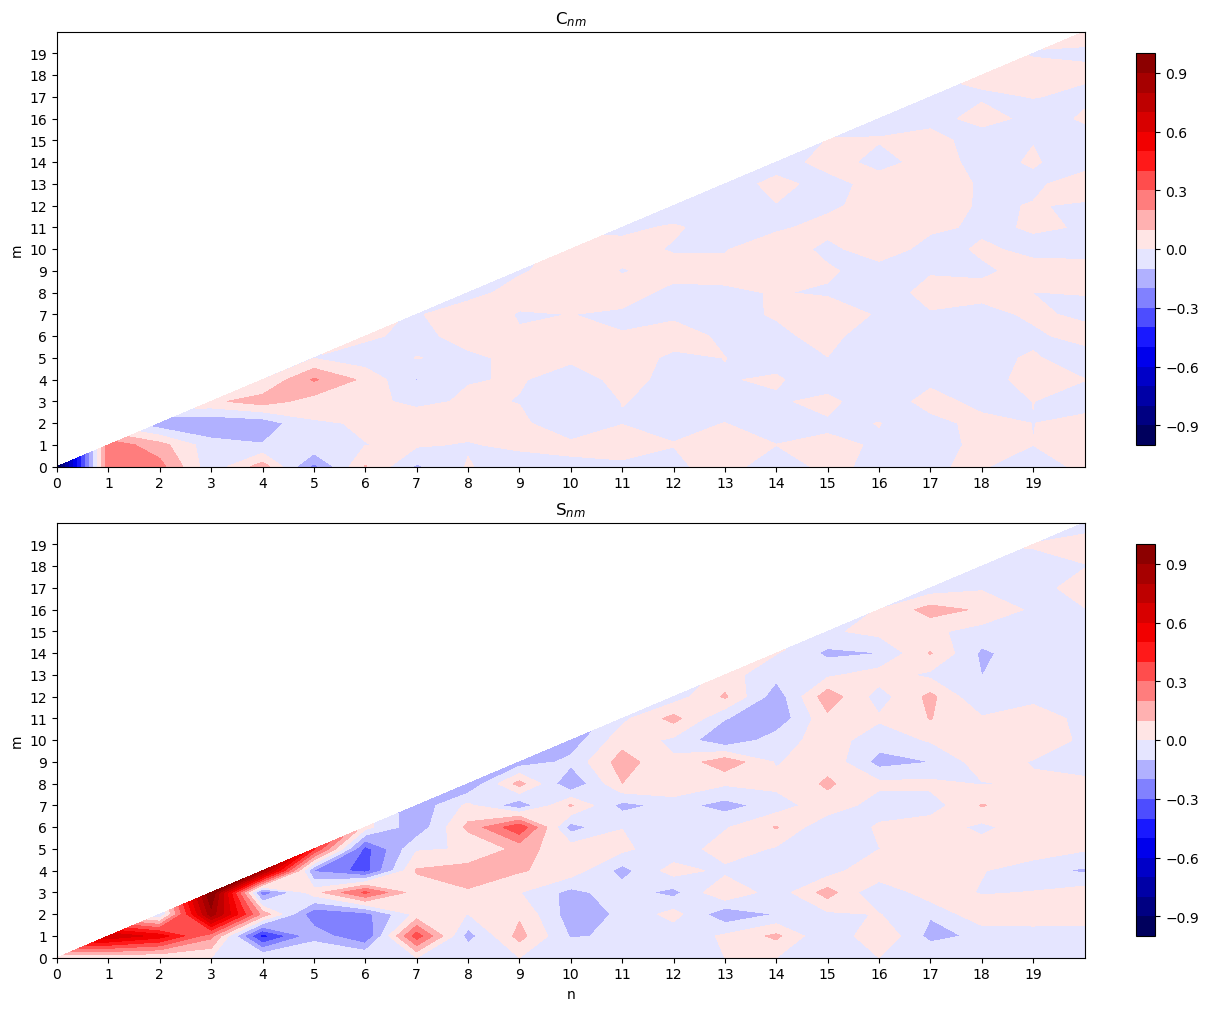

In [6]:
fig,axs = plt.subplots(2,1,figsize=(12,10),constrained_layout=True)
axs[0].set_title('C$_{nm}$')
axs[0].set_ylabel('m')
axs[1].set_title('S$_{nm}$')
axs[1].set_xlabel('n')
axs[1].set_ylabel('m')
axs[0].set_xlim([0,20])
axs[0].set_ylim([0,20])
axs[0].set_xticks([i for i in range(20)])
axs[0].set_yticks([i for i in range(20)])
axs[1].set_xlim([0,20])
axs[1].set_ylim([0,20])
axs[1].set_xticks([i for i in range(20)])
axs[1].set_yticks([i for i in range(20)])

levels=np.linspace(-1,1,21)
CS1 = axs[0].contourf(NN,MM,Cnm[:,:,0]/Cnm_max,levels=levels,cmap='seismic')
CS2 = axs[1].contourf(NN,MM,Cnm[:,:,1]/Snm_max,levels=levels,cmap='seismic')
cbar1 = fig.colorbar(CS1,ax=axs[0], shrink=0.9)
cbar2 = fig.colorbar(CS2,ax=axs[1], shrink=0.9)

----
## Power spectrum

Next, we plot the power spectrum of the coefficients:
$$
P_n = \sum\limits_{m=0}^{n} \sqrt{C_{nm}^2 + S_{nm}^2}
$$

In [7]:
degree = np.zeros(nmax+1)
power = np.zeros(nmax+1)
for n in range(nmax+1):
    degree[n] = n
    power[n] = 1e-7
    for m in range(n+1):
        degree[n] = n
        power[n]  = power[n] + np.sqrt(Cnm[n,m,0]**2 + Cnm[n,m,1]**2)

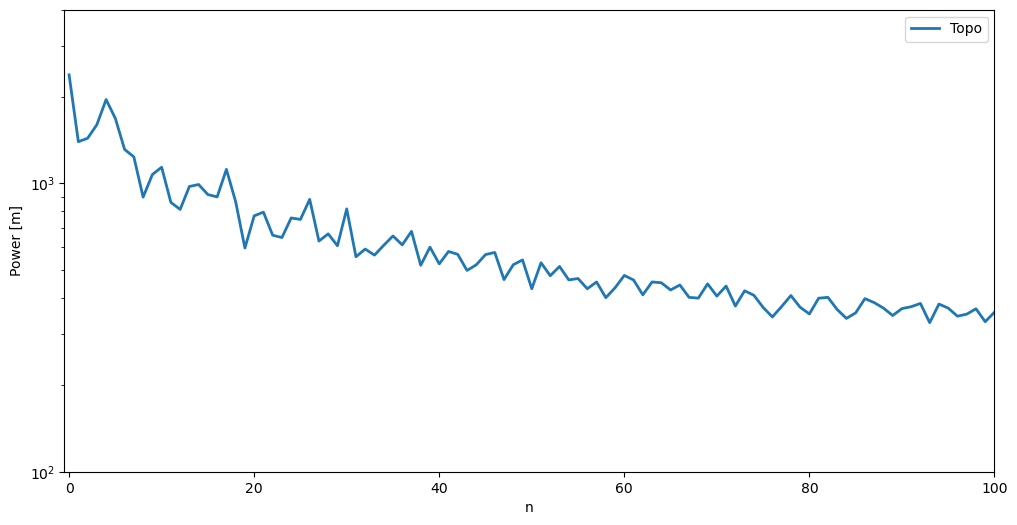

In [8]:
plt.figure(figsize=(12,6))
plt.xlabel('n')
plt.ylabel('Power [m]')
plt.xlim([-0.5,100])
plt.ylim([100,4000])
plt.semilogy(degree,power,linewidth=2,label='Topo')
plt.legend()

----
## Reconstruct topography

Define coordinates as sampling points:
- $\theta \in [0,180]$ co-latitude
- $\phi \in [0,360]$ longitude

In [9]:
# define coordinates (in radiants)
d2r   = np.pi/180.
dlong = 51; dcolat = 51
#dlong = 101; dcolat = 51
#dlong = 201; dcolat = 101
colat = np.linspace(0, np.pi, dcolat)
long  = np.linspace(0, 2*np.pi, dlong)
print(colat.shape)
colat, long = np.meshgrid(colat, long)
print(colat.shape)

(51,)
(51, 51)


Text(0.5, 1.0, 'Robinson Projection')

/opt/miniconda3/envs/python_R/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


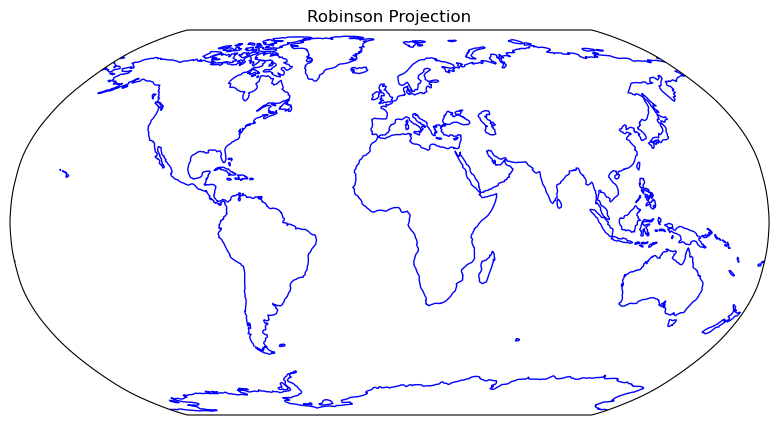

In [10]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(color='blue')
plt.title("Robinson Projection")

Re-assemble topography with summing up over spherical harmonics:
$$
U(\theta,\phi) = \sum\limits_{n=0}^{n_{max}} \sum\limits_{m=0}^{n} C_{nm} Y_{nm}(\theta,\phi)
$$

In [12]:
import warnings
warnings.filterwarnings('ignore')

(51, 51)


Text(0, 0.5, 'Topography [m]')

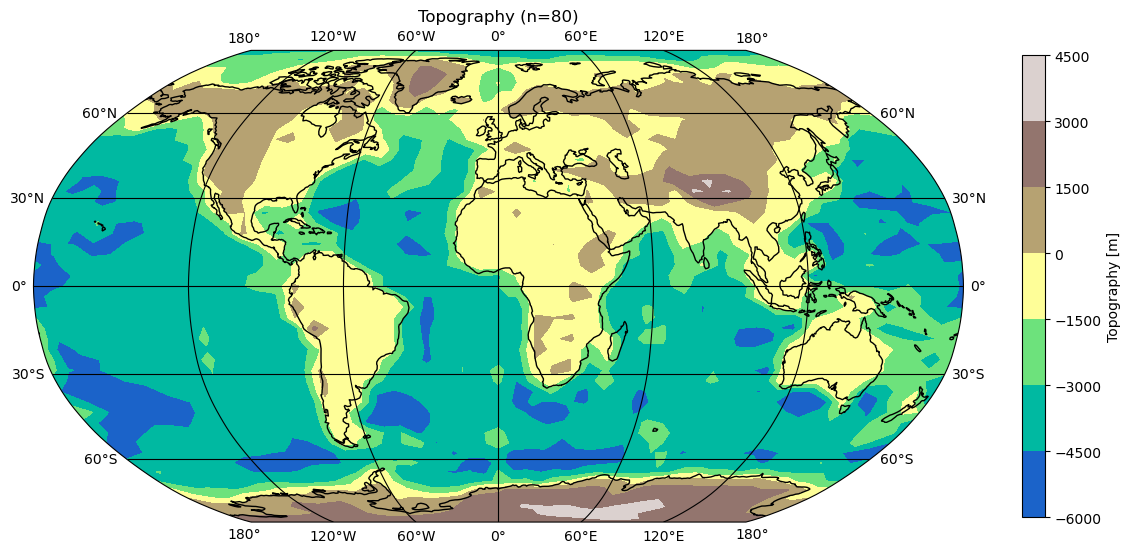

In [17]:
nmax = 80
# define topography as 2D array
topo = np.zeros(dlong*dcolat).reshape(dlong,dcolat)
print(topo.shape)

# assemble topography by summing up spherical harmonics
for n in range(nmax+1):
    for m in range(n+1):
        Ynm = sph_harm(m, n, long, colat) * np.sqrt(4*np.pi) # reverse 4pi normalisation to geodetic norm
        if not (np.isnan(Cnm[n,m,0])):
            if not (np.isnan(Cnm[n,m,1])):
                topo = topo + Cnm[n,m,0]*Ynm.real + Cnm[n,m,1]*Ynm.imag

# define figure, map projection, coastlines, and gridlines
fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black')
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black')
# plot geoid map on top, add color bar
axs.set_title('Topography (n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,topo,transform=ccrs.PlateCarree(),cmap='terrain')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('Topography [m]')

... done